# Shameless copy from [Stefan Petrushevski](https://www.kaggle.com/cokastefan) and [Raj Mehrotra](https://www.kaggle.com/rajmehra03)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, runniЃng this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resnet50', 'kk2flowers', 'flowers-recognition']


In [ ]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization,Dropout
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.utils import to_categorical
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random as rn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
#————————————————————————————————————————————————————
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='../input/kk2flowers/flowers_TRAIN/flowers_TRAIN/daisy'
FLOWER_SUNFLOWER_DIR='../input/kk2flowers/flowers_TRAIN/flowers_TRAIN/sunflower'
FLOWER_TULIP_DIR='../input/kk2flowers/flowers_TRAIN/flowers_TRAIN/tulip'
FLOWER_DANDI_DIR='../input/kk2flowers/flowers_TRAIN/flowers_TRAIN/dandelion'
FLOWER_ROSE_DIR='../input/kk2flowers/flowers_TRAIN/flowers_TRAIN/rose'

def assign_label(img,flower_type):
    return flower_type

def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        _, ftype = os.path.splitext(path)
        if ftype == ".jpg":
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X.append(np.array(img))
            Z.append(str(label))


            
            
            
#————————————————————————————————————————————————————
X1=[]
Z1=[]
#IMG_SIZE1=150
FLOWER_DAISY_DIR1='../input/kk2flowers/flowers_TEST/flowers_TEST/daisy'
FLOWER_SUNFLOWER_DIR1='../input/kk2flowers/flowers_TEST/flowers_TEST/sunflower'
FLOWER_TULIP_DIR1='../input/kk2flowers/flowers_TEST/flowers_TEST/tulip'
FLOWER_DANDI_DIR1='../input/kk2flowers/flowers_TEST/flowers_TEST/dandelion'
FLOWER_ROSE_DIR1='../input/kk2flowers/flowers_TEST/flowers_TEST/rose'

#def assign_label(img,flower_type):
    #return flower_type

def make_test_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        _, ftype = os.path.splitext(path)
        if ftype == ".jpg":
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X1.append(np.array(img))
            Z1.append(str(label))

            

In [ ]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
make_train_data('Tulip',FLOWER_TULIP_DIR)
make_train_data('Dandelion',FLOWER_DANDI_DIR)
make_train_data('Rose',FLOWER_ROSE_DIR)



make_test_data('Daisy',FLOWER_DAISY_DIR1)
make_test_data('Sunflower',FLOWER_SUNFLOWER_DIR1)
make_test_data('Tulip',FLOWER_TULIP_DIR1)
make_test_data('Dandelion',FLOWER_DANDI_DIR1)
make_test_data('Rose',FLOWER_ROSE_DIR1)

100%|██████████| 84/84 [00:00<00:00, 325.36it/s]


In [ ]:
#-------------------------------------------------------
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

#-------------------------------------------------------
#le=LabelEncoder()
Y1=le.fit_transform(Z1)
Y1=to_categorical(Y1,5)
X1=np.array(X1)
X1=X1/255


######################
print(X.shape)
print(X1.shape)
#x_train,x_val,y_train,y_val=train_test_split(X,Y,test_size=0.1,random_state=42)

x_train = X
y_train = Y
x_test = X1
y_test = Y1

np.random.seed(42)

(3500, 150, 150, 3)
(420, 150, 150, 3)


In [ ]:
batch_size=64
epochs=50

from tensorflow.python.keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5)

#monitor='val_acc',

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [ ]:
model = Sequential()

model.add(ResNet50(include_top=False, pooling='max', weights=resnet_weights_path))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

model.layers[0].trainable = False

In [ ]:
from tensorflow.python.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_v1_3 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
__________

In [ ]:
# count = sum([len(files) for r, d, files in os.walk("../input/flowers-recognition/flowers/flowers/")])

History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[red_lr])
                              #validation_data = (x_val,y_val))

Epoch 1/50
55/55 [==============================] - 18s 321ms/step - loss: 0.7939 - acc: 0.7511
Epoch 2/50
55/55 [==============================] - 17s 309ms/step - loss: 0.5180 - acc: 0.8334
Epoch 3/50
55/55 [==============================] - 17s 315ms/step - loss: 0.4099 - acc: 0.8537
Epoch 4/50
55/55 [==============================] - 18s 332ms/step - loss: 0.3499 - acc: 0.8789
Epoch 5/50
55/55 [==============================] - 17s 315ms/step - loss: 0.3043 - acc: 0.8880
Epoch 6/50
55/55 [==============================] - 17s 316ms/step - loss: 0.2788 - acc: 0.9046
Epoch 7/50
55/55 [==============================] - 17s 317ms/step - loss: 0.2636 - acc: 0.9037
Epoch 8/50
55/55 [==============================] - 18s 329ms/step - loss: 0.2357 - acc: 0.9163
Epoch 9/50
55/55 [==============================] - 17s 310ms/step - loss: 0.1997 - acc: 0.9274
Epoch 10/50
55/55 [==============================] - 17s 316ms/step - loss: 0.2085 - acc: 0.9257
Epoch 11/50
55/55 [====================

Epoch 28/50
55/55 [==============================] - 18s 331ms/step - loss: 0.1088 - acc: 0.9583
Epoch 29/50
55/55 [==============================] - 17s 315ms/step - loss: 0.1097 - acc: 0.9569
Epoch 30/50
55/55 [==============================] - 17s 313ms/step - loss: 0.1322 - acc: 0.9549
Epoch 31/50
55/55 [==============================] - 18s 332ms/step - loss: 0.1019 - acc: 0.9629
Epoch 32/50
55/55 [==============================] - 17s 317ms/step - loss: 0.1161 - acc: 0.9611
Epoch 33/50
55/55 [==============================] - 17s 316ms/step - loss: 0.1050 - acc: 0.9629
Epoch 34/50
55/55 [==============================] - 17s 314ms/step - loss: 0.1059 - acc: 0.9660
Epoch 35/50
55/55 [==============================] - 18s 335ms/step - loss: 0.1077 - acc: 0.9609
Epoch 36/50
55/55 [==============================] - 17s 313ms/step - loss: 0.1035 - acc: 0.9634
Epoch 37/50
55/55 [==============================] - 17s 313ms/step - loss: 0.0836 - acc: 0.9709
Epoch 38/50
55/55 [===========

In [ ]:
#final_loss, final_accuracy = model.evaluate(x_val, y_val)
#print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

final_loss, final_accuracy = model.evaluate(x_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

420/420 [==============================] - 2s 4ms/sample - loss: 0.2394 - acc: 0.9357
Final Loss: 0.23943055779479133, Final Accuracy: 0.9357143044471741


KeyError: 'val_acc'

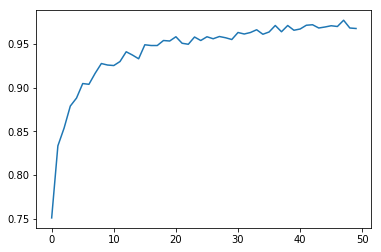

In [ ]:
import matplotlib.pyplot as plt
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [ ]:

# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower :"+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1